<a href="https://colab.research.google.com/github/omarsayed7/RSNA-Pneumonia-Detection/blob/classification/RSNA_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pydicom

     |████████████████████████████████| 35.3MB 89kB/s 


In [4]:
import os, shutil, random, cv2
import glob, pylab, pandas as pd
import pydicom, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import keras 
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Flatten
import  keras.optimizers as optimizers
from keras.layers.convolutional import Convolution2D, MaxPooling2D 

from keras.utils import plot_model
keras.__version__

Using TensorFlow backend.


'2.3.1'

# Data download

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarsayed7","key":"381fb01dc8dc1a948731f4a326853459"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 3.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=15e8141ea1977e8730d09ce7acf8018be0bec2cb5599329cd0b36dfb4fe50d5f
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6


In [8]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [01:05<00:00, 12.8MB/s]
100% 3.66G/3.66G [01:06<00:00, 59.6MB/s]


In [9]:
!unzip rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_train_images/d539e101-5662-445c-9f6a-381e674f0aed.dcm  
  inflating: stage_2_trai

# Overview

We’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs, a special 2D high resolution grayscale medical image. Note that pnuemonia is just one of many possible disease processes that can occur on a chest radiograph, and that any given single image may contain 0, 1 or many boxes corresponding to possible pneumonia locations.



In [0]:
!ls

'GCP Credits Request Link - RSNA.txt'	  stage_2_sample_submission.csv
 kaggle.json				  stage_2_test_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_images
 sample_data				  stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


## Files description

`stage_2_detailed_class_info.csv`: Contains detailed information about the positive and negative classes in the training set

`stage_2_train_labels.csv`: CSV file containing training set patientIds and labels (including bounding boxes)

`stage_2_train_images`: Directory containing training set raw image (DICOM) files

`stage_2_test_images`: Directory containing test set raw image (DICOM) files

### Considerations
The training data is provided as a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x-min y-min width height

There is also a binary target column, Target, indicating pneumonia or non-pneumonia.

There may be multiple rows per patientId.

In [0]:
train_labels = pd.read_csv('stage_2_train_labels.csv')
data_info = pd.read_csv('stage_2_detailed_class_info.csv')
sample_submission = pd.read_csv('stage_2_sample_submission.csv')

In [0]:
sample_submission.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [0]:
data_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [0]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [0]:
sample = train_labels.iloc[0,:]
sample2 = train_labels.iloc[15,:]

In [0]:
sample

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object

In [0]:
sample2

patientId    00aecb01-a116-45a2-956c-08d2fa55433f
x                                             547
y                                             299
width                                         119
height                                        165
Target                                          1
Name: 15, dtype: object

As you can see the training data information consists of:

`patiendId` One unique value for each patient

`Target` Either 0 or 1 for absence or presence of pneumonia, respectively 

`x and y` The center of the bounding box, if the Target is 0 the value of x and y will be **NaN**

`width and height` The width and the height of the bounding box, if the Target is 0 the value of the width and the height will be **NaN**


---



### DICOM Images

All provided images are in DICOM format `(.dcm)`, DICOM(Digital Imaging and Communications in Medicine) is the international standard to transmit, store, retrieve, print, process, and display medical imaging information.

To make python deal with this format we are going to use `Pydicom` 

In [0]:
patientId = train_labels['patientId'][0]
dcm_file = 'stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In order to get the pixel data from this metadata


In [0]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


# Statistics 

In [0]:
print('Number of rows (unique boxes per patient) in main train dataset:', train_labels.shape[0])
print('Number of unique patient IDs:', train_labels['patientId'].nunique())


Number of rows (unique boxes per patient) in main train dataset: 30227
Number of unique patient IDs: 26684


Target
0    0.683892
1    0.316108
dtype: float64


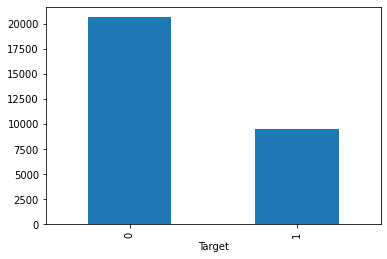

In [0]:
train_labels.groupby('Target').size().plot.bar()
print(train_labels.groupby('Target').size() / train_labels.shape[0])

## Detailed Class Info Data

However we may use the detailed information that been listed in `stage_2_detailed_class_info.csv`.

We revisit what is inside that file 



In [0]:
data_info.head(6)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


class
Lung Opacity                    0.316108
No Lung Opacity / Not Normal    0.391074
Normal                          0.292818
dtype: float64


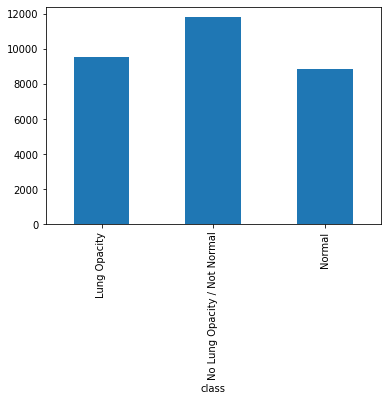

In [0]:
data_info.groupby('class').size().plot.bar()
print(data_info.groupby('class').size() / train_labels.shape[0])

As you can see we can add a new column called class to the training data, that will help us build more nuanced models.

Now we got general target called `Target` which contains only two classes `0 and 1`, 
and detailed target calsses `No Lung Opacity / Not Normal, Normal and Lung Opacity`

# Data preperation

In [0]:
train_data = pd.concat([train_labels,data_info['class']], axis = 1)

In [0]:
train_data.head(7)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [0]:
unique_train_data = train_data.drop_duplicates(subset= 'patientId')

In [0]:
unique_train_data.head(6)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


class
Lung Opacity                    0.225304
No Lung Opacity / Not Normal    0.443000
Normal                          0.331697
dtype: float64


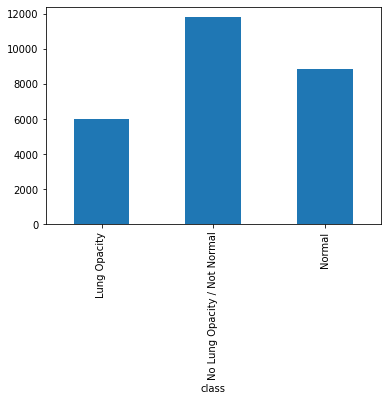

In [0]:
unique_train_data.groupby('class').size().plot.bar()
print(unique_train_data.groupby('class').size() / unique_train_data.shape[0])

# Visualization 

## Utility functions 

In [0]:
def get_sample(dataframe, img_dir, patientId):
  '''
  helper function used to parse a sample from the data 
  args:
  dataframe: pandas dataframe (e.g train, test)
  img_dir: directory to data images (.dcm)
  patientId: unique Id of the patient

  returns:
  gray scale image of the patient, bouding box values, target, patient_class  
  '''
  x =[]
  y = []
  h = []
  w = []
  for i,j in zip(dataframe['patientId'],range(len(dataframe))):
    if i == patientId:
      patient = dataframe.iloc[j,:]
      x.append(patient[1])
      y.append(patient[2])
      w.append(patient[3])
      h.append(patient[4])
      target = patient[5]
      p_class = patient[6]
      
  dcm_data = img_dir+'/%s.dcm' % patientId
  dcm_data = pydicom.read_file(dcm_data)
  img = dcm_data.pixel_array
  
  return img, x, y, h, w, target, p_class

In [0]:
def draw(img, x, y, h, w):
  '''
  helper function used to draw a bounding box/s of the areas of the lung
  args:
  img: grayscale image of the pateint's chest X-ray
  x,y,h,w: bounding box parameters 

  returns:
  grayscale images with drawn bounding box if exists
  '''
  fig,ax = plt.subplots(1)
  for x_sub,y_sub,h_sub,w_sub in zip(x, y, h, w):
    rect = patches.Rectangle((x_sub,y_sub),w_sub,h_sub,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  pylab.imshow(img, cmap=pylab.cm.gist_gray)
  ax.add_patch(rect)
  plt.show()


## Visualize Patients by ID

1 Lung Opacity


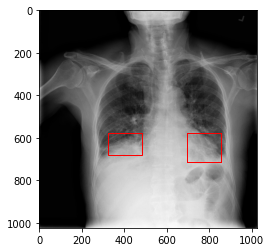

In [0]:
img, x, y, h, w, target, p_class = get_sample(dataframe=train_data,
                                              img_dir='stage_2_train_images',
                                              patientId='00704310-78a8-4b38-8475-49f4573b2dbb')
print(target, p_class)
draw(img,x,y,h,w)

1 Lung Opacity


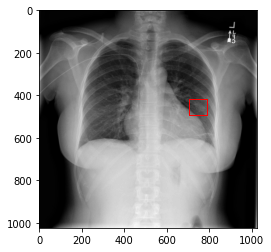

In [0]:
img, x, y, h, w, target, p_class = get_sample(dataframe=train_data,
                                              img_dir='stage_2_train_images',
                                              patientId='0100515c-5204-4f31-98e0-f35e4b00004a')
print(target, p_class)
draw(img,x,y,h,w)

0 No Lung Opacity / Not Normal


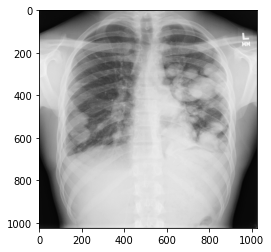

In [0]:
img, x, y, h, w, target, p_class = get_sample(dataframe=train_data,
                                              img_dir='stage_2_train_images',
                                              patientId='00322d4d-1c29-4943-afc9-b6754be640eb')
print(target, p_class)
draw(img,x,y,h,w)

0 Normal


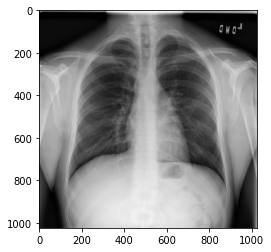

In [0]:
img, x, y, h, w, target, p_class = get_sample(dataframe=train_data,
                                              img_dir='stage_2_train_images',
                                              patientId='003d8fa0-6bf1-40ed-b54c-ac657f8495c5')
print(target, p_class)
draw(img,x,y,h,w)

# Data pre-processing

## Split the train data into `train` and `validation` 

**Note:** The following function mainly splits the training images which are `26684` image, and also wrap up a training and validation csv file for the unique patients ID.

In [0]:
def train_split(train_csv, img_dir, split_size = 0.2, base_dir = ''):
  '''
  function used to split the training data into train and validation set
  args:-
    train_csv: Pandas data frame contains all the training information (e.g patientId, x, y, w, etc.)
    img_dir: Path to training image directory 
    split_size: How much you want to split the validation set from the training data
    base_dir: Base directory to join it with img_dir

  returns:
    training_info and validation_info: Those two dataframes contain all the information after spliting 
  '''

  train_dir = os.path.join(base_dir,'train')
  validation_dir = os.path.join(base_dir,'validation')
  if not os.path.exists(train_dir):
    os.mkdir(train_dir)
  if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

  training_info = pd.DataFrame(columns=train_csv.columns)
  validation_info = pd.DataFrame(columns=train_csv.columns)

  training_indices = list(range(len(train_csv)))
  random.shuffle(training_indices)
  split_size = (1-split_size)*len(training_indices)

  training_idx = training_indices[:int(split_size)]
  validation_idx = training_indices[int(split_size):]

  for t_patient in training_idx:
    patient = train_csv.iloc[t_patient,:]
    patientId = patient[0]
    src = os.path.join(img_dir, patientId+'.dcm')
    dst = os.path.join(train_dir, patientId+'.dcm')
    shutil.copyfile(src, dst)
    training_info = training_info.append(patient, ignore_index=True)
    
  for v_patient in validation_idx:
    patient = train_csv.iloc[v_patient,:]
    patientId = patient[0]
    src = os.path.join(img_dir, patientId+'.dcm')
    dst = os.path.join(validation_dir, patientId+'.dcm')
    shutil.copyfile(src, dst)
    validation_info = validation_info.append(patient, ignore_index=True)

  print('total training data:', len(os.listdir(train_dir)))
  print('total validation data:', len(os.listdir(validation_dir)))  
  return training_info, validation_info

In [14]:
training_info, validation_info = train_split(unique_train_data,'stage_2_train_images')

total training data: 21347
total validation data: 5337


In [15]:
print(len(training_info), len(validation_info))

21347 5337


## Data generator

In [0]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self,data_csv, img_dir, batch_size=32, dim=(256,256), 
               n_classes=2, n_channels=1, shuffle=True,
               classes ={'Normal':0,'No Lung Opacity / Not Normal':1,'Lung Opacity': 2}, debug = False):
    '''Initialization
    args:-
      data_csv:
      img_dir:
      batch_size:
      dim:
      n_channels:
      n_classes:
      self.classes:
      shuffle:
    '''
    self.data_csv = data_csv
    self.patientIds = self.data_csv['patientId']
    self.img_dir = img_dir 
    self.batch_size = batch_size
    self.dim = dim
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.classes = classes
    self.shuffle = shuffle
    self.debug = debug
    self.on_epoch_end()

  def __len__(self):
    '''Denotes the number of batches per epoch
        returns:-
          number of batches per epoch'''
    return int(np.floor(len(self.data_csv) / self.batch_size))

  def __getitem__(self,index):
    '''Generate one batch of data 
      args:- 
        index: index of the batch   
      returns:
        imgs and labels when fitting, imgs only when predicting'''
    #Generate indexes of the batch    
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]    
    
    #Find the list of patientIds
    list_IDs_batch = [self.patientIds[k] for k in indexes]

    imgs, labels = self.__data_generation(list_IDs_batch)
    
    if self.debug:
      return list_IDs_batch, imgs, labels 
    else :
      return imgs, labels

  def on_epoch_end(self):
    '''
    Updates indexes after each epoch
      '''
    self.indexes = np.arange(len(self.data_csv))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_batch):
    '''
    Generates data containing batch_size samples
    args:-
        list_Ids_batch: lsit of the patientIds of specific batch number 
    return:-
        imgs: An array of the patients images with shape (n_samples, *dim, n_channels) == 4D tensor
        labels: An array of encoded labels'''
    imgs = np.empty((self.batch_size, *self.dim, self.n_channels))
    labels = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(list_IDs_batch):
      #Store patient image
      imgs[i,] = self.load_img(self.img_dir, ID, self.dim)
      labels[i] = self.get_label(ID, self.n_classes)

    
    return imgs, keras.utils.to_categorical(labels, num_classes=self.n_classes)


  def load_img(self, img_dir, patientId,dim):
    dcm_data = img_dir+'/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_data)
    img = dcm_data.pixel_array
    img = cv2.resize(img,dim)
    img = img.reshape((dim[0],dim[1],1))
    img = np.float32(img) / 255
    return img  

  def get_label(self,patientId, n_classes):
    full_info = train_data.loc[train_data['patientId'] == patientId].values
    if n_classes == 2:
      return int(full_info[0][-2]) #get the corresponding numerical value (0,1)
    elif n_classes == 3:
      class_label = full_info[:,-1] #get class type (e.g Normal, Lung Opacity)
      class_string = class_label[0] 
      return int(self.classes[class_string]) #get the corresponding numerical value (0,1,2)

In [0]:
train_generator = DataGenerator(data_csv = training_info, img_dir='train',
                                batch_size=32, dim=(256,256), n_classes=2)

validation_generator = DataGenerator(data_csv = validation_info, img_dir='validation',
                                batch_size=32, dim=(256,256), n_classes=2)

In [0]:
train_generator = DataGenerator(data_csv = training_info, img_dir='train',
                                batch_size=32, dim=(256,256), n_classes=3)

validation_generator = DataGenerator(data_csv = validation_info, img_dir='validation',
                                batch_size=32, dim=(256,256), n_classes=3)

In [18]:
print("Number of batches for training set= ", len(train_generator))
print("Number of batches for validation set= ", len(validation_generator))

Number of batches for training set=  667
Number of batches for validation set=  166


In [0]:
def show_batch(generator, batch_number):
  '''
  docs 
  '''
  print("The number of batches for this data = ", len(generator))
  
  batch = generator.__getitem__(batch_number)
  ID = batch[0]
  imgs = batch[1]
  labels= batch[2]
  w=50
  h=50
  fig=plt.figure(figsize=(25, 25))
  columns = 4
  rows = 4
  for i in range(1, columns*rows):
    img = imgs[i]
    img = np.squeeze(img, axis = 2)
    fig.add_subplot(rows, columns, i)
    plt.title(str(ID[i])+'  '+str(labels[i]), fontsize = 10)
    plt.imshow(img, cmap='gray')
  plt.show()

The number of batches for this data =  667


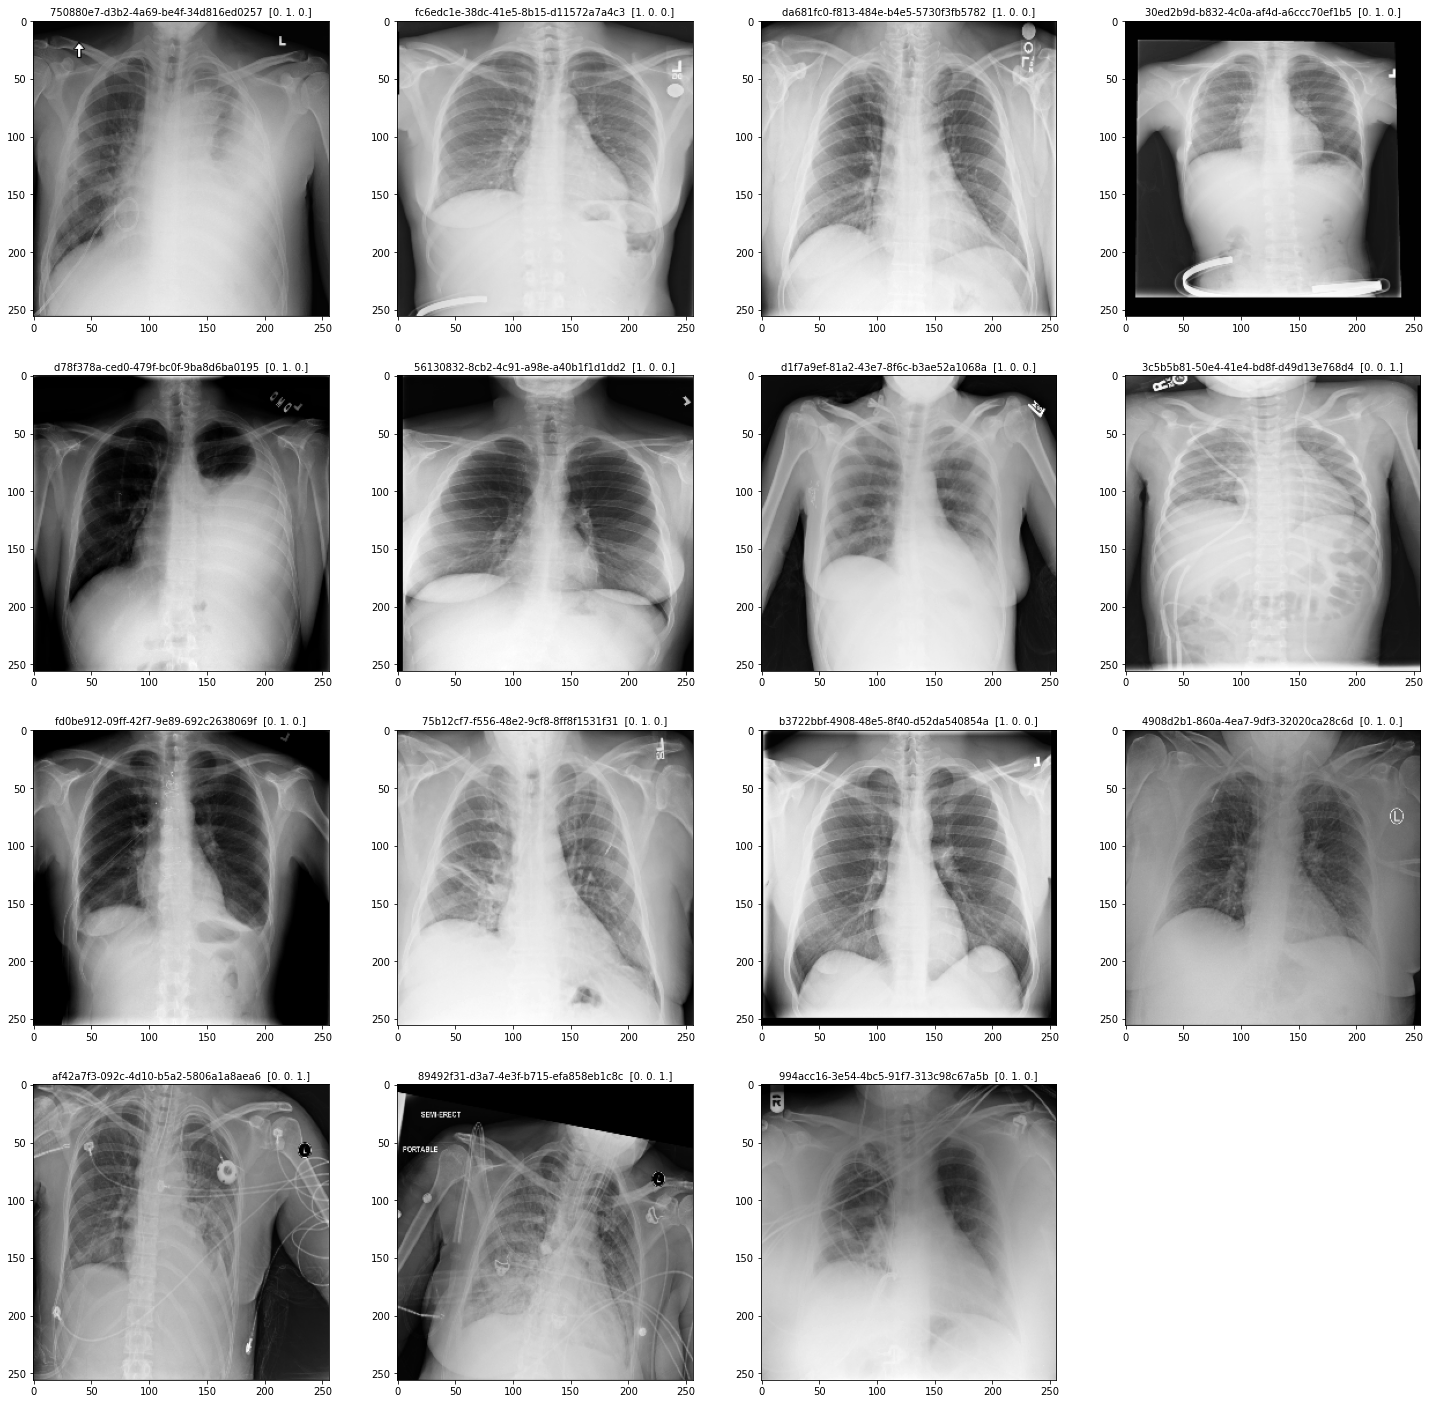

In [545]:
show_batch(train_generator, 2)

# Classification Model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)      544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 123, 16)      8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5953

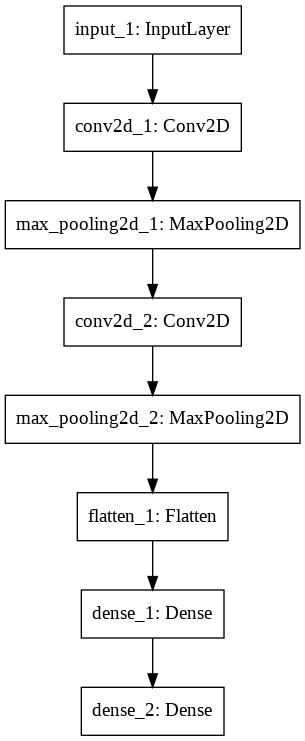

In [19]:
input_img = Input(shape=(256,256,1))
conv1 = Convolution2D(32, kernel_size=4, activation='relu')(input_img)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Convolution2D(16, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
hidden1 = Dense(10, activation='relu')(flat)
output = Dense(3, activation='softmax')(hidden1)
model = Model(inputs=input_img, outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [20]:
#params = {'dim': (32,32,32),
#          'batch_size': 64,
#          'n_classes': 6,
#          'n_channels': 1,
#          'shuffle': True}

# Generators
#training_generator = DataGenerator(partition['train'], labels, **params)
#validation_generator = DataGenerator(partition['validation'], labels, **params)

# Train model on dataset
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.fit_generator(generator=train_generator,
                  validation_data=validation_generator,use_multiprocessing =True)

Epoch 1/1
667/667 [==============================] - 320s 480ms/step - loss: 0.9440 - acc: 0.5304 - val_loss: 0.7768 - val_acc: 0.5346


# References 
* [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge?rvi=1)
* [Data exploratory Data Analysis](https://www.kaggle.com/peterchang77/exploratory-data-analysis)
* [Deep Learning With Python Book, Jason Brownlee](https://machinelearningmastery.com/deep-learning-with-python/)
* [Machine Learning Mastery](https://machinelearningmastery.com/)
* [Sequence class documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)